In [35]:
import kagglehub

import warnings
warnings.filterwarnings("ignore")
import random

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import shuffle

In [2]:
#https://www.kaggle.com/datasets/whenamancodes/fraud-detection
path = kagglehub.dataset_download("whenamancodes/fraud-detection")
print("Path to dataset files:", path)
df = pd.read_csv(path + "\\creditcard.csv")
display(df.head())
print(df.shape)

Path to dataset files: C:\Users\miaje\.cache\kagglehub\datasets\whenamancodes\fraud-detection\versions\1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)


---
#### About this dataset

* Contains transactions made by credit cards in September 2013 by European cardholders.
* Presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
* Highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
* Contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Due to confidentiality issues, the original features and more background information about the data cannot be provided. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
df_fraud = df[df.Class == 1]
df_legit = df[df.Class == 0]
print(f"{round((df_fraud.shape[0] / df.shape[0])*100, 2)}% fraudulent")

0.17% fraudulent


---
#### Prepare for Modelling

In [12]:
data = df.drop(columns=["Class"])

In [20]:
random_state = 42

---
#### Fit Model

In [23]:
iso = IsolationForest(
    n_estimators=400,
    max_samples='auto',
    contamination='auto',  #threshold to be set once SME labels have been collected
    bootstrap=False,
    n_jobs=-1,
    random_state=random_state
)
iso.fit(data)
iso_scores = pd.Series(-iso.decision_function(data), index=data.index, name="iso_scores")
iso_scores

0        -0.111381
1        -0.128098
2        -0.041707
3        -0.088497
4        -0.108488
            ...   
284802    0.127997
284803   -0.089250
284804   -0.087800
284805   -0.069267
284806   -0.107500
Name: iso_scores, Length: 284807, dtype: float64

---
#### Propose sample for SMEs to review

In [24]:
proposed = propose_for_review(iso_scores, top_n=200, mid_sample=200, random_state=random_state)
initial_queue = (
    pd.DataFrame({"if_score": iso_scores.loc[proposed]})
    .assign(priority_rank=lambda df: df["if_score"].rank(ascending=False, method="first"))
    .sort_values("priority_rank")
)
initial_queue

,if_score,priority_rank
274771,0.269610,1.0
173353,0.259433,2.0
58465,0.252023,3.0
151296,0.249298,4.0
173054,0.248989,5.0
...,...,...
225634,-0.085207,396.0
76570,-0.085475,397.0
9481,-0.085877,398.0
277567,-0.086053,399.0


In [75]:
# manually label
random.seed(random_state)
sme_labels = random.choices([1, 0], weights=[0.1, 0.9], k=len(initial_queue))
sme_labels_batch = initial_queue.copy()
sme_labels_batch["label"] = sme_labels
sme_labels_batch

,if_score,priority_rank,label
274771,0.269610,1.0,0
173353,0.259433,2.0,1
58465,0.252023,3.0,0
151296,0.249298,4.0,0
173054,0.248989,5.0,0
...,...,...,...
225634,-0.085207,396.0,0
76570,-0.085475,397.0,0
9481,-0.085877,398.0,0
277567,-0.086053,399.0,0


---
#### Build Labelled Dataset

In [83]:
sme_labels_batch

,if_score,priority_rank,label
274771,0.269610,1.0,0
173353,0.259433,2.0,1
58465,0.252023,3.0,0
151296,0.249298,4.0,0
173054,0.248989,5.0,0
...,...,...,...
225634,-0.085207,396.0,0
76570,-0.085475,397.0,0
9481,-0.085877,398.0,0
277567,-0.086053,399.0,0


In [89]:
labeled_idx = data.index.intersection(sme_labels_batch.index)
y = sme_labels_batch.loc[labeled_idx, "label"].astype(int)
s = iso_scores.loc[labeled_idx].values
X_lab = data.loc[labeled_idx]
X_lab = X_lab.assign(iso_scores=s)  # add IF score as a feature
X_lab = X_lab.assign(y_true=y)      # add SME labels as a feature
X_lab, y = shuffle(X_lab, y, random_state=random_state) # shuffle to reduce ordering bias
X_lab

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,iso_scores,y_true
150863,94072.0,2.093565,0.374606,-2.241651,1.242640,1.157453,-0.906527,0.810864,-0.579656,1.181907,0.010939,-0.785936,-2.813288,1.483014,2.270758,-0.509469,-0.200609,-0.043358,0.230861,-0.206100,-0.248243,-0.029276,0.216958,-0.205057,-1.057265,0.661234,-0.394393,-0.072916,-0.078620,36.00,-0.076067,0
195307,130994.0,-0.026155,1.694994,1.193312,4.360895,0.903547,0.500497,1.025948,-0.345599,-2.009850,1.876554,-0.576370,-0.276988,0.768616,-0.034829,0.294059,-0.565142,0.195283,-0.526489,1.270445,0.233358,-0.144724,-0.262458,0.138517,1.118738,-1.022282,-0.090831,-0.214005,0.015875,9.81,-0.073850,0
12378,21691.0,1.284671,-0.328441,0.434072,-0.895204,-0.242579,0.506583,-0.732411,0.089729,3.138784,-1.508889,-0.455758,-1.936616,2.212620,1.155769,0.847958,-0.372600,0.335084,0.423752,0.516008,-0.108544,-0.216255,-0.089454,-0.181657,-1.354192,0.600191,-0.611106,0.082040,0.013991,11.85,-0.059298,0
151006,94362.0,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,4.419997,-10.592305,-0.703796,-3.926207,-2.400246,-6.809890,-12.462315,-5.501051,-0.567940,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.00,0.225607,1
42549,41147.0,-5.314173,4.145944,-8.532522,8.344392,-5.718008,-3.043536,-10.989185,3.404129,-6.167234,-11.435624,7.674534,-14.296091,0.526939,-15.445026,0.991651,-12.391346,-22.541652,-7.986721,2.992554,1.150017,2.331466,0.862996,-0.614453,0.523648,-0.712593,0.324638,2.245091,0.497321,88.23,0.187969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19608,30406.0,1.261103,1.184655,-1.924636,1.343517,1.245123,-1.046946,0.617822,-0.154250,-0.562772,-1.363661,1.682381,-0.371099,-0.653655,-3.116709,0.494217,1.500287,2.189065,2.169080,-0.233030,-0.033967,-0.219250,-0.592604,-0.316881,-0.837627,0.918053,-0.258545,0.031150,0.077301,1.79,-0.050248,0
48331,43593.0,-0.623517,-0.152621,1.264414,-0.796581,-0.885945,0.568086,-1.198656,-2.499531,0.560865,-1.608707,-1.645054,0.184343,-0.376292,-0.026290,-0.231918,0.926782,-0.545057,-0.091396,-0.562517,0.893539,-1.351064,-0.184243,-0.321199,-0.398598,0.842944,0.962648,-0.061962,0.215540,179.40,-0.066426,1
188560,128027.0,-12.895214,-20.492129,-12.794629,4.691974,-17.515077,15.568823,28.069822,-2.149673,-4.346561,-6.737942,-0.191043,-2.332976,1.009000,1.677601,0.834934,0.140747,-0.691036,2.779350,-1.311423,17.141052,4.956184,0.718607,17.768462,-0.166671,3.655826,-0.343445,-2.708680,0.500650,7766.60,0.206117,0
231454,146772.0,-35.905105,-31.041362,-19.472908,9.216960,-18.863553,10.713326,16.687265,-9.609234,3.296559,-1.368484,2.545327,1.882563,3.727829,0.418748,5.501117,7.059132,-0.955952,-2.113101,-0.083183,-21.964898,-2.661701,-3.016337,-19.331255,0.987774,-2.180899,-0.172480,6.228140,-2.830091,3552.96,0.247778,0


----
#### Determine New Threshold and Get Legitimate Rows

In [96]:
precision, recall, thresholds = precision_recall_curve(y, s)

p = precision[:-1]
r = recall[:-1]
f1 = 2 * p * r / (p + r + 1e-12)

best_ix = int(np.nanargmax(f1))
chosen_threshold = float(thresholds[best_ix])
best_f1 = float(f1[best_ix])
best_p, best_r = float(p[best_ix]), float(r[best_ix])

print({"Threshold": chosen_threshold, "Best F1": best_f1, "Best Precision": best_p, "Best Recall": best_r})

{'Threshold': 0.19910722492340627, 'Best F1': 0.1882352941172935, 'Best Precision': 0.12213740458015267, 'Best Recall': 0.41025641025641024}


In [107]:
X_lab_legit = pd.concat([
    X_lab[X_lab.y_true == 1], 
    X_lab[(X_lab.iso_scores < chosen_threshold) & (X_lab.y_true == 0)]
], axis=0, ignore_index=True)
X_lab_legit = X_lab_legit.drop(columns=["iso_scores", "y_true"])
X_lab_legit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,94362.0,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,4.419997,-10.592305,-0.703796,-3.926207,-2.400246,-6.809890,-12.462315,-5.501051,-0.567940,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.00
1,143863.0,-41.928738,-40.803981,-22.588759,11.844703,-8.729597,3.281296,14.203189,-5.245286,4.874533,1.363213,4.018141,1.048973,3.789116,-3.704008,5.720479,6.442798,1.091949,-1.417654,-0.635708,-14.157629,-5.862383,-3.433164,-21.303666,1.321750,-4.084350,-0.601799,-2.787339,-0.816680,200.00
2,24532.0,-13.911336,9.508117,-17.506256,6.112442,-11.191653,-3.937424,-13.051697,9.407979,-2.918901,-9.875331,7.749594,-12.151584,1.195298,-9.387624,-0.648015,-8.064117,-14.153147,-4.832993,1.391892,1.486919,1.570180,-1.119134,-0.486481,0.028497,0.832399,-0.277975,1.745969,0.554760,89.99
3,17520.0,-5.268053,9.067613,-15.960728,10.296603,-4.708241,-3.395375,-11.161057,5.499963,-5.667376,-11.627194,11.027059,-16.388054,0.363921,-17.230202,-0.437488,-10.122392,-13.639209,-4.986457,1.126784,1.455878,2.004110,0.191058,0.622928,-1.209264,-0.374799,0.648798,1.584697,0.720056,1.00
4,42951.0,-23.712839,-42.172688,-13.320825,9.925019,-13.945538,5.564891,15.710644,-2.844253,-1.580725,-5.533256,1.446695,0.902675,1.746979,2.354131,0.801598,2.068475,1.413407,0.748320,-3.637371,26.237391,7.921600,-6.320710,-11.310338,0.404175,-4.547278,-1.577118,-2.357385,2.253662,12910.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,50219.0,-1.329964,0.216691,2.702195,-0.573818,-1.406446,0.963046,-1.082950,1.317405,1.404586,-1.135984,-0.319514,-0.406618,-3.678586,-0.155729,-2.145797,-0.143790,0.675788,0.044448,0.096638,-0.305169,-0.042796,0.118107,-0.239597,0.030870,0.136855,1.096788,0.136053,0.037052,1.00
281,172605.0,-0.054804,0.539229,-0.785936,-1.359666,0.052568,-1.269691,0.591211,0.123632,-1.867227,0.259018,0.216923,0.006207,-0.911740,1.009965,-1.574886,-1.794610,0.073230,1.285897,-0.539764,-0.771646,-0.103069,0.099001,-0.158142,0.093863,-0.064144,0.734388,-0.156006,-0.059705,2.00
282,18690.0,-15.398845,7.472324,-19.026912,11.165526,-6.893856,-2.120937,-14.913330,-0.721214,-7.175097,-14.166795,10.277769,-14.985434,0.345179,-14.666389,-0.346353,-8.333242,-12.602596,-4.876683,0.604626,1.111502,-2.444884,0.727495,-0.345078,-0.981749,0.995271,0.816762,2.262942,-1.178063,1.00
283,86326.0,-9.759245,-12.793382,-5.470780,5.187856,-14.858619,8.389511,18.585208,-1.148948,-3.693047,-4.845059,-0.402079,-1.613996,0.609469,1.106974,0.931528,1.427508,-0.403177,1.515139,-2.540418,11.310330,3.187310,-0.333174,12.214433,-0.267406,2.403722,-0.177034,-1.910145,0.386038,5268.04


----
#### Retrain on Legitimate Rows

In [108]:
iso2 = IsolationForest(
    n_estimators=400,
    max_samples='auto',
    contamination=threshold,
    bootstrap=False,
    n_jobs=-1,
    random_state=random_state
)
iso2.fit(X_lab_legit)
iso_scores2 = pd.Series(-iso2.decision_function(data), index=data.index, name="iso_scores2")
iso_scores2

0        -0.128794
1        -0.136466
2        -0.103858
3        -0.120779
4        -0.130846
            ...   
284802   -0.025904
284803   -0.118269
284804   -0.125872
284805   -0.106803
284806   -0.131997
Name: iso_scores2, Length: 284807, dtype: float64

In [ ]:
# train and fit a new isolation forest model on labelled data
def train_supervised_with_calibration(X_lab: pd.DataFrame, y: pd.Series, base_model=None, method="isotonic", random_state=0):
    if base_model is None:
        base_model = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced", n_jobs=-1, random_state=random_state)
    # keep a holdout for evaluation and thresholding
    X_tr, X_val, y_tr, y_val = train_test_split(X_lab, y, test_size=0.25, stratify=y, random_state=random_state)
    cal = CalibratedClassifierCV(base_model, method=method, cv=5)
    cal.fit(X_tr, y_tr)
    # evaluate
    val_probs = cal.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_probs)
    print(f"Validation Average Precision (PR AUC): {ap:.3f}")
    return cal, (X_val, y_val)

In [ ]:
# assemble the pipeline
def full_cycle(X_all, sme_labels_batch=None, daily_quota=200, beta=None, random_state=0):
    """
    One training/scoring cycle.
    - Fit isolation forest (IF)
    - If provided labels exist, train supervised + calibrate and set threshold.
    - Produce a queue for next SME review batch.
    """
    iso, if_scores = fit_isolation_forest(X_all, random_state=random_state)

    if sme_labels_batch is None or len(sme_labels_batch) == 0:
        # Cold start: just send a smart batch for review
        proposed = propose_for_review(if_scores, top_n=200, mid_sample=200, random_state=random_state)
        initial_queue = (
            pd.DataFrame({"if_score": if_scores.loc[proposed]})
            .assign(priority_rank=lambda df: df["if_score"].rank(ascending=False, method="first"))
            .sort_values("priority_rank")
        )
        print("Cold-start review batch prepared (no labels yet).")
        return {"iso_model": iso, "if_scores": if_scores, "review_queue": initial_queue}

    # Build labeled dataset
    X_lab, y = build_labeled_dataset(X_all, if_scores, sme_labels_batch)
    display(X_lab)
    # Shuffle to reduce any ordering bias
    X_lab, y = shuffle(X_lab, y, random_state=random_state)

    cal_model, (X_val, y_val) = train_supervised_with_calibration(X_lab, y, method="isotonic", random_state=random_state)
    val_probs = cal_model.predict_proba(X_val)[:, 1]

    if beta is not None:
        thr = choose_threshold_for_fbeta(y_val, val_probs, beta=beta)
        queue, probs, chosen_threshold = score_and_queue(X_all, if_scores, cal_model, threshold=thr)
    else:
        # Workload-based default
        queue, probs, chosen_threshold = score_and_queue(X_all, if_scores, cal_model, daily_quota=daily_quota)

    print(f"Chosen threshold: {chosen_threshold:.4f}")

    # Plots using precision_recall_fscore_support
    # On the validation set across thresholds:
    plot_prfs_vs_threshold(
        y_true=y_val.values,
        probs=val_probs,
        title="Validation Precision/Recall/F1 vs Threshold"
    )
    # At the chosen operational threshold (still on validation set):
    plot_prfs_bars(
        y_true=y_val.values,
        probs=val_probs,
        threshold=chosen_threshold,
        title=f"Validation metrics @ threshold={chosen_threshold:.3f}"
    )

    return {
        "iso_model": iso,
        "if_scores": if_scores,
        "calibrated_model": cal_model,
        "chosen_threshold": chosen_threshold,
        "review_queue": queue
    }

In [6]:
def plot_prfs_vs_threshold(y_true, probs, thresholds=None, title=None):
    """
    Plots Precision, Recall, and F1 vs. probability threshold,
    using sklearn.metrics.precision_recall_fscore_support at each threshold.
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    prec, rec, f1 = [], [], []
    for t in thresholds:
        y_pred = (probs >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        prec.append(p); rec.append(r); f1.append(f)

    plt.figure()
    plt.plot(thresholds, prec, label="Precision")
    plt.plot(thresholds, rec, label="Recall")
    plt.plot(thresholds, f1, label="F1")
    plt.xlabel("Probability threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.show()


def plot_prfs_bars(y_true, probs, threshold, title=None):
    """
    Bar chart of Precision, Recall, and F1 at a specific threshold,
    computed with precision_recall_fscore_support.
    """
    y_pred = (probs >= threshold).astype(int)
    p, r, f, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    plt.figure()
    plt.bar(["Precision", "Recall", "F1"], [p, r, f])
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    plt.grid(axis="y", linewidth=0.3, alpha=0.5)
    plt.show()

In [7]:
# train and fit and isolation forest model on unlabelled data
def fit_isolation_forest(X, random_state=0):
    iso = IsolationForest(
        n_estimators=400,
        max_samples='auto',
        contamination='auto',  #threshold to be set once SME labels have been collected
        bootstrap=False,
        n_jobs=-1,
        random_state=random_state
    )
    iso.fit(X)
    anom_score = -iso.decision_function(X)
    return iso, pd.Series(anom_score, index=X.index, name="if_score")

# collect a sample of data for SMEs to review
# should include: top N high scores, plus some diverse/uncertain mid-score samples
def propose_for_review(scores: pd.Series, top_n=200, mid_quantile_range=(0.70, 0.90), mid_sample=200, random_state=0):
    rng = np.random.default_rng(random_state)
    # top N scores
    top_idx = scores.sort_values(ascending=False).head(top_n).index
    # mid scores
    q_low, q_high = scores.quantile([mid_quantile_range[0], mid_quantile_range[1]])
    mid_pool = scores[(scores >= q_low) & (scores <= q_high)]
    mid_n = min(mid_sample, len(mid_pool))
    mid_idx = rng.choice(mid_pool.index, size=mid_n, replace=False) if mid_n > 0 else []
    # combine all samples
    proposed = pd.Index(top_idx).append(pd.Index(mid_idx)).unique()
    return proposed

# after collecting actual labels from SMEs, create new dataset with "label" column
def build_labeled_dataset(X_all: pd.DataFrame, if_scores: pd.Series, sme_labels: pd.DataFrame):
    labeled_idx = X_all.index.intersection(sme_labels["expense_id"])
    y = sme_labels.set_index("expense_id").loc[labeled_idx, "label"].astype(int)
    X_lab = X_all.loc[labeled_idx].copy()
    X_lab = X_lab.assign(if_score=if_scores.loc[labeled_idx].values)  # add IF score as a feature
    return X_lab, y


# train and fit a new isolation forest model on labelled data
def train_supervised_with_calibration(X_lab: pd.DataFrame, y: pd.Series, base_model=None, method="isotonic", random_state=0):
    if base_model is None:
        # robust baseline
        # handles non-linearities
        # set class_weight for imbalance
        base_model = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced", n_jobs=-1, random_state=random_state)
    # keep a holdout for evaluation and thresholding
    X_tr, X_val, y_tr, y_val = train_test_split(X_lab, y, test_size=0.25, stratify=y, random_state=random_state)
    cal = CalibratedClassifierCV(base_model, method=method, cv=5)
    cal.fit(X_tr, y_tr)
    # evaluate
    val_probs = cal.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_probs)
    print(f"Validation Average Precision (PR AUC): {ap:.3f}")
    return cal, (X_val, y_val)

# select a decision rule (threshold):
# (a) business-cost oriented (maximize F_beta)
def choose_threshold_for_fbeta(y_true, probs, beta=2.0):
    precision, recall, thresh = precision_recall_curve(y_true, probs)
    # avoid div-by-zero
    fbeta = (1 + beta**2) * (precision * recall) / np.clip(beta**2 * precision + recall, 1e-12, None)
    best_i = np.nanargmax(fbeta)
    # precision_recall_curve returns len(thresh) = len(precision)-1
    # map index accordingly
    if best_i == len(thresh): best_i -= 1
    return float(thresh[best_i])

# (b) workload oriented (top-K per batch/day)
def choose_threshold_for_topk(probs, k):
    if k <= 0 or k > len(probs):
        raise ValueError("k must be in (0, len(probs)].")
    kth = np.sort(probs)[-k]  # value at rank k
    return float(kth)

# score and queue all samples for SME review
def score_and_queue(X_all: pd.DataFrame, if_scores: pd.Series, cal_model, threshold=None, daily_quota=None):
    X_aug = X_all.assign(if_score=if_scores.values)
    probs = pd.Series(cal_model.predict_proba(X_aug)[:, 1], index=X_all.index, name="anomaly_prob")
    if daily_quota is not None and threshold is None:
        # Workload-based: take top-N each day
        queue_idx = probs.sort_values(ascending=False).head(daily_quota).index
        chosen_threshold = float(probs.loc[queue_idx].min())
    else:
        if threshold is None:
            # Fallback: default to top 1% if nothing else is provided
            threshold = np.quantile(probs, 0.99)
        queue_idx = probs[probs >= threshold].index
        chosen_threshold = float(threshold)
    queue = pd.DataFrame({
        "anomaly_prob": probs.loc[queue_idx],
        "if_score": if_scores.loc[queue_idx]
    }).sort_values("anomaly_prob", ascending=False)
    return queue, probs, chosen_threshold


# assemble the pipeline
def full_cycle(X_all, sme_labels_batch=None, daily_quota=200, beta=None, random_state=0):
    """
    One training/scoring cycle.
    - Fit isolation forest (IF)
    - If provided labels exist, train supervised + calibrate and set threshold.
    - Produce a queue for next SME review batch.
    """
    iso, if_scores = fit_isolation_forest(X_all, random_state=random_state)

    if sme_labels_batch is None or len(sme_labels_batch) == 0:
        # Cold start: just send a smart batch for review
        proposed = propose_for_review(if_scores, top_n=200, mid_sample=200, random_state=random_state)
        initial_queue = (
            pd.DataFrame({"if_score": if_scores.loc[proposed]})
            .assign(priority_rank=lambda df: df["if_score"].rank(ascending=False, method="first"))
            .sort_values("priority_rank")
        )
        print("Cold-start review batch prepared (no labels yet).")
        return {"iso_model": iso, "if_scores": if_scores, "review_queue": initial_queue}

    # Build labeled dataset
    X_lab, y = build_labeled_dataset(X_all, if_scores, sme_labels_batch)
    display(X_lab)
    # Shuffle to reduce any ordering bias
    X_lab, y = shuffle(X_lab, y, random_state=random_state)

    cal_model, (X_val, y_val) = train_supervised_with_calibration(X_lab, y, method="isotonic", random_state=random_state)
    val_probs = cal_model.predict_proba(X_val)[:, 1]

    if beta is not None:
        thr = choose_threshold_for_fbeta(y_val, val_probs, beta=beta)
        queue, probs, chosen_threshold = score_and_queue(X_all, if_scores, cal_model, threshold=thr)
    else:
        # Workload-based default
        queue, probs, chosen_threshold = score_and_queue(X_all, if_scores, cal_model, daily_quota=daily_quota)

    print(f"Chosen threshold: {chosen_threshold:.4f}")

    # Plots using precision_recall_fscore_support
    # On the validation set across thresholds:
    plot_prfs_vs_threshold(
        y_true=y_val.values,
        probs=val_probs,
        title="Validation Precision/Recall/F1 vs Threshold"
    )
    # At the chosen operational threshold (still on validation set):
    plot_prfs_bars(
        y_true=y_val.values,
        probs=val_probs,
        threshold=chosen_threshold,
        title=f"Validation metrics @ threshold={chosen_threshold:.3f}"
    )

    return {
        "iso_model": iso,
        "if_scores": if_scores,
        "calibrated_model": cal_model,
        "chosen_threshold": chosen_threshold,
        "review_queue": queue
    }

Cold-start review batch prepared (no labels yet).


,if_score,priority_rank
274771,0.268831,1.0
173353,0.247708,2.0
151296,0.246237,3.0
58465,0.244590,4.0
220090,0.239858,5.0


,expense_id,label
0,274771,0
1,173353,0
2,151296,0
3,58465,0
4,220090,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,if_score
731,550.0,-1.203351,1.774641,0.299300,-0.418265,0.484617,0.071523,0.046899,-1.492543,0.308865,0.271295,-1.532808,-0.702163,-0.258116,-0.485220,1.057280,0.787660,-0.357701,0.382133,0.350550,0.035568,1.100059,-1.561118,0.054078,-1.119103,0.145057,0.182843,0.528716,0.218048,2.67,-0.076067
1384,1074.0,-2.445204,-0.505494,0.164511,-0.449658,0.460784,-0.509035,-0.490478,1.060597,-0.385591,-1.053488,-0.553817,0.207330,-0.933946,0.969621,-0.758698,0.863809,-0.533855,0.559857,0.502850,0.171937,0.060361,-0.802101,-0.299229,-0.831608,-0.055518,0.315454,-0.467257,-0.167591,1.00,-0.085606
1632,1264.0,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,-2.636622,3.702177,-1.843056,2.427123,-1.652836,3.635042,4.087802,-1.654892,-0.888406,0.752276,-11.748689,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43,0.214275
2095,1614.0,-2.962376,2.607363,-0.067883,-0.889316,-1.360313,-0.983393,-0.534070,1.473261,0.478763,0.706617,0.721613,1.005330,-0.837317,0.779043,-0.961018,0.400195,0.030062,-0.045642,-0.202505,0.420581,-0.185342,-0.455737,0.160595,0.506340,0.078372,0.299425,0.544370,0.349456,1.00,-0.069467
3619,3094.0,-0.302521,0.447474,-0.495757,-3.214799,2.705041,2.762440,0.593847,0.556451,0.697720,-1.090181,-0.111088,0.062652,-0.238457,0.215738,1.069356,-0.255231,-1.072085,0.485110,0.271315,0.156089,0.007343,0.250886,-0.331600,1.009952,0.233730,-0.824471,0.241305,-0.020359,1.00,-0.071358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283399,171565.0,2.190208,-1.963704,0.459281,-1.294053,-2.247734,0.556156,-2.374559,0.308539,0.200355,1.308331,-1.747234,-0.697872,0.284969,-1.491509,-0.841293,-0.327028,0.579036,0.517388,-0.117367,-0.414138,-0.027399,0.653444,0.253390,0.671646,-0.404998,-0.053334,0.096183,-0.020795,18.17,-0.080824
283492,171635.0,-0.501657,0.813920,-0.668644,-1.025468,1.649166,1.688387,0.277851,0.920540,-0.313646,-0.859430,-0.664322,0.827168,0.980358,0.331360,0.660601,-1.028067,0.621156,-2.468926,-1.354056,-0.130041,-0.130454,-0.223878,0.204565,-1.302547,-0.630721,0.277561,0.191599,0.006267,11.99,-0.076263
283658,171768.0,-2.467223,2.253708,0.281877,4.260362,-0.553394,1.299202,-0.592281,1.061158,-0.725846,2.750826,-1.618971,-0.093822,1.292422,-0.238490,0.701280,0.289972,0.107926,0.595924,0.956358,0.515915,0.130433,1.004529,-0.085599,0.517418,-0.373533,0.427202,0.000554,-0.090862,40.04,-0.059351
284249,172273.0,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,-7.776435,0.214173,-4.499851,0.241005,0.537895,2.901938,2.326099,-0.402142,1.257379,2.008145,2.454553,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0.205153


Validation Average Precision (PR AUC): 0.055
Chosen threshold: 0.0925


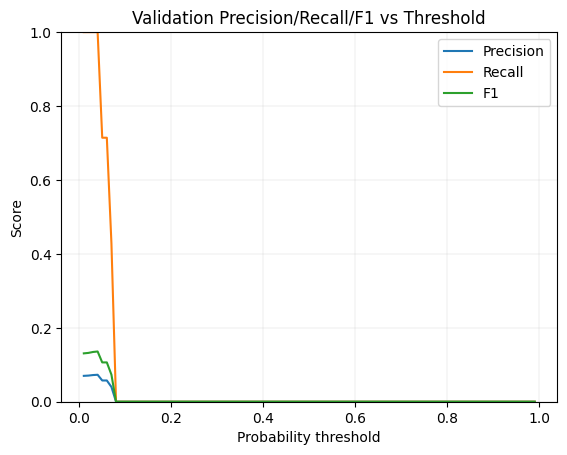

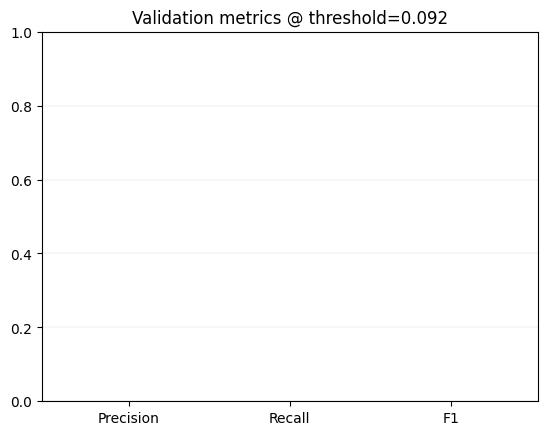

In [11]:
response = "Class"
X_all = df.drop(columns=[response])
# y = df[response]

# cold start to get SMEs labeling:
cycle0 = full_cycle(X_all)
len_cycle = len(cycle0["review_queue"])
display(cycle0["review_queue"].head())

# SMEs review those expense_ids and return a DataFrame
import random
random.seed(30)
sme_labels_batch = pd.DataFrame({
    "expense_id": cycle0["review_queue"].index,
    "label": random.choices([0, 1], weights=[0.9, 0.1], k=len_cycle)  # 1 = anomalous, 0 = legitimate
})
display(sme_labels_batch.head())

# train with feedback and produce next queue
cycle1 = full_cycle(X_all, sme_labels_batch=sme_labels_batch, daily_quota=200, random_state=0)

# on subsequent days/weeks, append new labels and re-run full_cycle with the growing label set.